In [20]:
import logging
from IPython.core.interactiveshell import InteractiveShell
%load_ext autoreload
InteractiveShell.ast_node_interactivity = "all"

logging.basicConfig(
    level=logging.DEBUG, format="%(asctime)s - %(name)s - %(levelname)s - %(message)s"
)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [21]:
import sys
import os

module_path = os.path.abspath(os.path.join(".."))
if module_path not in sys.path:
    sys.path.append(module_path)

# Explore AlphaPeptDeep

## Load models and data

In [13]:
from peptdeep.pretrained_models import ModelManager
import torch

device = str(torch.device("cuda:0" if torch.cuda.is_available() else "cpu"))
models = ModelManager()
models.load_installed_models()

rt_model = models.rt_model
rt_model.get_parameter_num()

ccs_model = models.ccs_model
ccs_model.get_parameter_num()

708224

713452

In [6]:
from alphabase.psm_reader import psm_reader_provider

mq_reader = psm_reader_provider.get_reader("maxquant")
mq_reader.load(
    "/cmnfs/proj/ORIGINS/data/tims_ramp_time/combined/txt/evidence_100ms.txt"
)

,sequence,charge,rt,ccs,mobility,scan_num,raw_name,precursor_mz,score,proteins,genes,decoy,intensity,spec_idx,mods,mod_sites,nAA,rt_norm
0,RLDFDYK,2,7.0780,349.06583,0.859103,2685,Hela2ug_lowflow_30min_1to37to42_NCE29to59_100m...,478.745442,83.265,Q99961;Q99962,SH3GL1;SH3GL2,0,85631.0,2684,,,7,0.251260
1,YHFLEER,2,6.4243,352.57886,0.868208,3170,Hela2ug_lowflow_30min_1to37to42_NCE29to59_100m...,497.243067,93.262,Q96I59,NARS2,0,29130.0,3169,,,7,0.228055
2,ECFYIPK,2,10.3380,361.38986,0.889433,2683,Hela2ug_lowflow_30min_1to37to42_NCE29to59_100m...,478.730946,84.359,Q16719,KYNU,0,317050.0,2682,Carbamidomethyl@C,2,7,0.366986
3,HFEEAFK,2,5.0897,349.33362,0.859103,2335,Hela2ug_lowflow_30min_1to37to42_NCE29to59_100m...,454.219060,89.369,O15381,NVL,0,19214.0,2334,,,7,0.180678
4,RLIELYK,2,7.5152,354.11597,0.871242,2517,Hela2ug_lowflow_30min_1to37to42_NCE29to59_100m...,467.789653,87.323,P37837,TALDO1,0,67838.0,2516,,,7,0.266780
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37947,TALLDAAGVASLLTTAEVVVTEIPKEEKDPGMGAMGGMGGGMGGGMF,3,28.0820,774.07710,1.284555,73724,Hela2ug_lowflow_30min_1to37to42_NCE29to59_100m...,1508.732810,135.590,P10809,HSPD1,0,108950.0,73723,,,47,0.996876
37948,AASAAGAAGSAGGSSGAAGAAGGGAGAGTRPGDGGTASAGAAGPGAATK,4,6.3659,955.33980,1.188167,71103,Hela2ug_lowflow_30min_1to37to42_NCE29to59_100m...,918.185360,34.127,Q9UKY7,CDV3,0,24554.0,71102,,,49,0.225982
37949,AASAAGAAGSAGGSSGAAGAAGGGAGAGTRPGDGGTASAGAAGPGAATK,3,6.3659,670.65424,1.112133,71104,Hela2ug_lowflow_30min_1to37to42_NCE29to59_100m...,1223.911390,273.280,Q9UKY7,CDV3,0,1177200.0,71103,,,49,0.225982
37950,LAGDGVGAVNISVMNSTGGSSSGGGIGLTLGGTMGSNALSFSSSAG...,3,22.8740,773.16320,1.283077,73795,Hela2ug_lowflow_30min_1to37to42_NCE29to59_100m...,1523.425080,58.811,CON__P08729;P08729;CON__Q3KNV1,KRT7,0,105280.0,73794,,,51,0.811999


In [8]:
maxquant = pd.read_csv(
    "/cmnfs/proj/ORIGINS/data/tims_ramp_time/combined/txt/evidence_100ms.txt", sep="\t"
)

In [17]:
test_df = pd.merge(
    left=maxquant,
    right=predict_df[["scan_num", "raw_name", "rt_pred"]],
    left_on=["MS/MS scan number", "Raw file"],
    right_on=["scan_num", "raw_name"],
    how="left",
)

## Misc

### Does RT normalization work as expected?

In [11]:
psm_df = mq_reader.psm_df
lc_grad = psm_df["rt"].max()
psm_df["rt_norm_check"] = psm_df["rt"] / lc_grad
(psm_df["rt_norm_check"] == psm_df["rt_norm"]).sum() / len(psm_df)

1.0

In [17]:
from utils.metrics import RT_metrics

lc_grad = mq_reader.psm_df["rt"].max()


def rescale_and_get_delta95(predict_df, lc_grad, obs_col, pred_col):
    if pred_col == "rt_pred_grad":
        predict_df[pred_col] = predict_df["rt_pred"] * lc_grad

    ori_rt_eval = RT_metrics(predict_df[obs_col], predict_df[pred_col])

    return ori_rt_eval.CalcDeltaRTwidth()

### Is CCS --> IM conversion accurate?

In [ ]:
from alphabase.peptide.mobility import ccs_to_mobility_for_df

psm_df["converted_mobility"] = ccs_to_mobility_for_df(psm_df, "ccs")
_rescale_and_get_delta95(
    predict_df, lc_grad=lc_grad, obs_col="mobility", pred_col="converted_mobility"
)

2.255877937562545e-06

yes it is.

## Original model

In [18]:
psm_df = mq_reader.psm_df
predict_df = rt_model.predict(psm_df)
from peptdeep.utils import evaluate_linear_regression, evaluate_linear_regression_plot
from prepare_dict.prepare_dict import _rescale_and_get_delta95

evaluate_linear_regression_plot(predict_df, x="rt_pred", y="rt_norm")
evaluate_linear_regression(predict_df, x="rt_pred", y="rt_norm")
_rescale_and_get_delta95(
    predict_df, lc_grad=lc_grad, obs_col="rt", pred_col="rt_pred_grad"
)

<Axes: xlabel='rt_pred', ylabel='rt_norm'>

,R_square,R,slope,intercept,test_num
0,0.895856,0.946497,0.788631,0.014814,37952


NameError: name 'rescale_and_get_delta95' is not defined

<Axes: xlabel='mobility_pred', ylabel='mobility'>

,R_square,R,slope,intercept,test_num
0,0.955002,0.977242,0.900643,0.094463,37952


0.05565508542473985

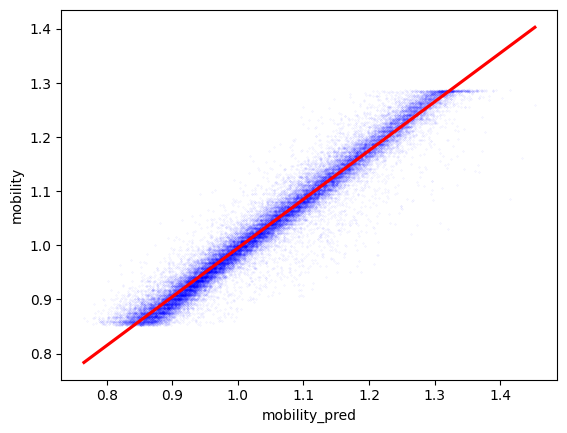

In [27]:
predict_df = ccs_model.predict(psm_df)
from alphabase.peptide.mobility import ccs_to_mobility_bruker

predict_df["mobility_pred"] = ccs_to_mobility_for_df(predict_df, "ccs_pred")
from peptdeep.utils import evaluate_linear_regression, evaluate_linear_regression_plot

evaluate_linear_regression_plot(predict_df, x="mobility_pred", y="mobility")
evaluate_linear_regression(predict_df, x="mobility_pred", y="mobility")
_rescale_and_get_delta95(
    predict_df, lc_grad=lc_grad, obs_col="mobility", pred_col="mobility_pred"
)

## KNN-based RT calibration

In [66]:
from sklearn.neighbors import KNeighborsRegressor


def adjust_rt_pred(train_df, test_df, x="rt_pred", y="rt_norm", target="rt_adjust"):
    model = KNeighborsRegressor(n_neighbors=3, weights="distance")
    model.fit(train_df[x].values.reshape((-1, 1)), train_df[y].values.reshape((-1, 1)))
    test_df[target] = model.predict(test_df[x].values.reshape((-1, 1)))
    return test_df


import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(psm_df, test_size=0.1)

<Axes: xlabel='rt_adjust', ylabel='rt_norm'>

,R_square,R,slope,intercept,test_num
0,0.949884,0.97462,0.975634,0.013592,3796


2024-08-22 16:36:52> Delta95: 6.403932805448772


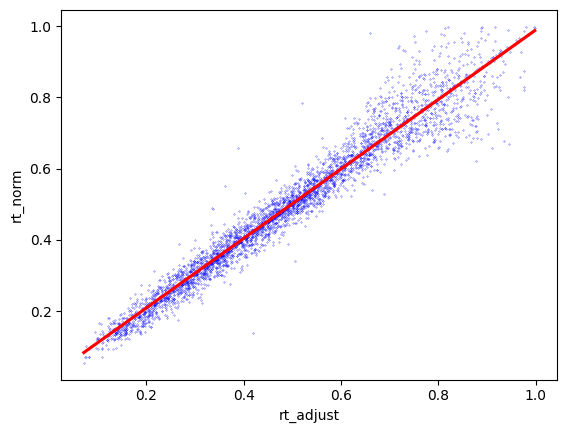

In [89]:
predict_df = adjust_rt_pred(train_df, test_df)
evaluate_linear_regression_plot(predict_df, x="rt_adjust", y="rt_norm")
evaluate_linear_regression(predict_df, x="rt_adjust", y="rt_norm")
logging.info(f"Delta95: {rescale_and_get_delta95(predict_df, lc_grad=lc_grad)}")

## Transfer learning

2024-08-22 16:48:46> Training with fixed sequence length: 0


Epoch=1, nAA=9, batch=65, loss=0.0116: 100%|██████████| 44/44 [00:03<00:00, 11.07it/s] 


[Training] Epoch=1, Mean Loss=0.010199120497474304


Epoch=2, nAA=43, batch=65, loss=0.0051: 100%|██████████| 44/44 [00:04<00:00, 10.79it/s]


[Training] Epoch=2, Mean Loss=0.010361430005958447


Epoch=3, nAA=39, batch=65, loss=0.0109: 100%|██████████| 44/44 [00:03<00:00, 11.64it/s]


[Training] Epoch=3, Mean Loss=0.010013206331775739


Epoch=4, nAA=9, batch=65, loss=0.0090: 100%|██████████| 44/44 [00:03<00:00, 11.61it/s] 


[Training] Epoch=4, Mean Loss=0.009975790060483491


Epoch=5, nAA=26, batch=65, loss=0.0109: 100%|██████████| 44/44 [00:03<00:00, 11.66it/s]


[Training] Epoch=5, Mean Loss=0.009600169920864014


<Axes: xlabel='rt_pred', ylabel='rt_norm'>

,R_square,R,slope,intercept,test_num
0,0.993765,0.996878,1.001238,0.001848,3796


2024-08-22 16:49:06> Testing Delta95: 0.7928445120155816
2024-08-22 16:49:08> Training Delta95: 0.7353137023448939


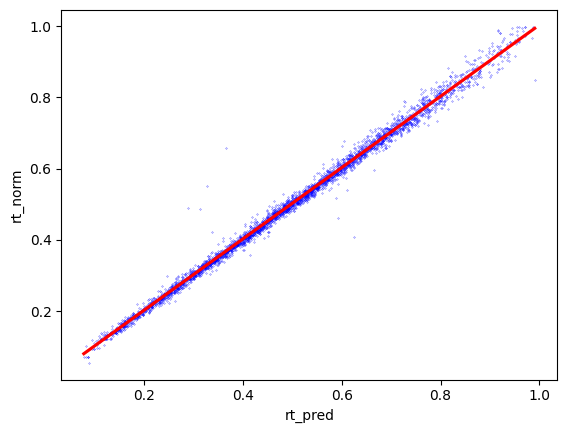

In [94]:
rt_model.train(train_df, epoch=5, verbose=True, verbose_each_epoch=True)
predict_df = rt_model.predict(test_df)
predict_df["mobility_pred"] = ccs_to_mobility_bruker(
    predict_df["ccs_pred"], predict_df["charge"], predict_df["precursor_mz"]
)
from peptdeep.utils import evaluate_linear_regression, evaluate_linear_regression_plot

evaluate_linear_regression_plot(predict_df, x="mobility_pred", y="mobility")
evaluate_linear_regression(predict_df, x="mobility_pred", y="mobility")
rescale_and_get_delta95(
    predict_df, lc_grad=lc_grad, obs_col="mobility", pred_col="mobility_pred"
)
logging.info(f"Testing Delta95: {rescale_and_get_delta95(predict_df, lc_grad=lc_grad)}")
predict_train_df = rt_model.predict(train_df)
logging.info(
    f"Training Delta95: {rescale_and_get_delta95(predict_train_df, lc_grad=lc_grad)}"
)

In [68]:
ccs_model = models.ccs_model
ccs_model.get_parameter_num()
# ccs_model.train(train_df, epoch=10, verbose=True, verbose_each_epoch=True)
predict_test_df = ccs_model.ccs_to_mobility_pred(test_df)
# predict_test_df["mobility_pred"] = ccs_to_mobility_for_df(test_df, "ccs_pred")
evaluate_linear_regression_plot(predict_test_df, x="mobility_pred", y="mobility")
evaluate_linear_regression(predict_test_df, x="mobility_pred", y="mobility")
logging.info(
    f"Testing Delta95: {rescale_and_get_delta95(predict_test_df, lc_grad=lc_grad, obs_col='mobility', pred_col='mobility_pred')}"
)
predict_train_df = ccs_model.ccs_to_mobility_pred(train_df)
# predict_train_df["mobility_pred"] = ccs_to_mobility_for_df(predict_train_df, "ccs_pred")
logging.info(
    f"Training Delta95: {rescale_and_get_delta95(predict_train_df, lc_grad=lc_grad, obs_col='mobility', pred_col='mobility_pred')}"
)

713452

<Axes: xlabel='mobility_pred', ylabel='mobility'>

,R_square,R,slope,intercept,test_num
0,0.9568,0.978162,0.900501,0.094669,3796


2024-08-23 19:04:46> Testing Delta95: 0.05483285437590124
2024-08-23 19:04:46> Training Delta95: 0.05577032980050045


## Save and load models

In [50]:
ccs_model.save("test/ccs_model")

In [51]:
ccs_loaded_model = models.ccs_model
ccs_loaded_model.load("test/ccs_model")

# Construct dict DEV

In [ ]:
from typing import Literal
from alphabase.psm_reader import psm_reader_provider

Logger = logging.getLogger(__name__)


def prepare_alpha_train_test_df(
    maxquant_path: str, train_frac: float, filter_dict: dict, random_state: int = 42
):
    # Load
    mq_reader = psm_reader_provider.get_reader("maxquant")
    mq_reader.load(
        maxquant_path,
    )
    psm_df = mq_reader.psm_df

    # Filter
    for key, value in filter_dict.items():
        psm_df = psm_df[psm_df[key].isin(value)]
        Logger.info(
            "psm_df size after filtering %s in %s: %s", key, value, psm_df.shape
        )

    # Normalize RT
    rt_max = psm_df["rt"].max()
    Logger.info(f"Max RT used for normalization: {rt_max}")
    psm_df["rt_norm"] = psm_df["rt"] / rt_max

    # Split
    train_df, test_df = train_test_split(
        psm_df, test_size=1 - train_frac, random_state=random_state
    )

    return train_df, test_df, rt_max


def update_alpha_pept_deep_model(
    pept_property: Literal["rt", "mobility"],
    train_df,
    test_df,
    save_dir: str,
    epoch=10,
):
    # init model
    models = ModelManager()
    models.load_installed_models()
    if pept_property == "rt":
        model = models.rt_model
    else:
        model = models.ccs_model

    # train
    model.train(train_df, epoch=epoch, verbose=True, verbose_each_epoch=False)

    # eval
    if pept_property == "mobility":
        predict_train_df = model.ccs_to_mobility_pred(train_df)
        predict_test_df = model.ccs_to_mobility_pred(test_df)
    else:
        predict_train_df = model.predict(train_df)
        predict_test_df = model.predict(test_df)
    delta_95_train = rescale_and_get_delta95(
        predict_train_df,
        lc_grad=lc_grad,
        obs_col=pept_property,
        pred_col=f"{pept_property}_pred",
    )
    delta_95_test = rescale_and_get_delta95(
        predict_test_df,
        lc_grad=lc_grad,
        obs_col=pept_property,
        pred_col=f"{pept_property}_pred",
    )
    Logger.info(f"Training Delta95: {delta_95_train}, Testing Delta95: {delta_95_test}")

    # save
    save_model_name = os.path.join(save_dir, f"{pept_property}_model")
    model.save(save_model_name)
    return delta_95_test, save_model_name


def dict_add_alpha_pept_pred(
    model, dict_path, pept_property, lc_grad: float | None = None
):
    # load dict
    dict = pd.read_csv(dict_path, sep="\t")
    Logger.info(f"dict size: {dict.shape}")
    mq_reader = psm_reader_provider.get_reader("maxquant")
    mq_reader.load(dict_path)
    dict_for_pred = mq_reader.psm_df
    Logger.info(f"dict_for_pred size: {dict_for_pred.shape}")

    # predict
    if pept_property == "mobility":
        predict_df = model.ccs_to_mobility_pred(psm_df)
    elif pept_property == "rt":
        assert lc_grad is not None
        predict_df = model.predict(psm_df)
        predict_df["rt_pred_grad"] = predict_df["rt_pred"] * lc_grad

    # merge
    dict = pd.merge(
        left=dict,
        right=predict_df,
        left_on=["MS/MS scan number", "Raw file"],
        right_on=["scan_number", "raw_file"],
        how="left",
    )
    Logger.info(
        "Number of entries with empty prediction: %s",
        dict[pept_property + "_pred"].isna().sum(),
    )
    dict = dict.dropna(subset=[pept_property + "_pred"])
    return dict

# config for construct dict

In [22]:
%autoreload 2
import logging
import os

import time
import fire

import pandas as pd
from datetime import datetime
from utils.ims_utils import (
    load_dotd_data,
    export_im_and_ms1scans,
    combine_3d_act_and_sum_int,
)
from utils.constants import exp_cols
from utils.config import get_cfg_defaults
from utils.singleton_swaps_optimization import swaps_optimization_cfg
from optimization.inference import process_ims_frames_parallel, generate_id_partitions
from result_analysis import result_analysis

# from result_analysis import result_analysis
from prepare_dict.prepare_dict import construct_dict

# from result_analysis import result_analysis
#config_path = "/cmnfs/proj/ORIGINS/SWAPS_exp/tims_ramp_time/120min_libaray_100ms_20240822_131204_977633/config_deeperCNN.yaml"
config_path = '/cmnfs/proj/ORIGINS/protMSD/maxquant/ScanByScan/utils/config_hela_120min_frac_100ms.yaml'
logging.basicConfig(
    format="%(asctime)s - %(name)s - %(levelname)s - %(message)s",
    level=logging.INFO,
)

cfg = get_cfg_defaults(swaps_optimization_cfg)
name_timestamp = datetime.now().strftime("%Y%m%d_%H%M%S_%f")
if config_path is not None:
    cfg.merge_from_file(config_path)
    logging.info("merge with cfg file %s", config_path)
if cfg.ADD_TIMESTAMP_TO_RESULT_PATH:
    cfg.RESULT_PATH = cfg.RESULT_PATH + "_" + name_timestamp
    cfg.ADD_TIMESTAMP_TO_RESULT_PATH = False  # in case of reuse of config file
logging.info("==================Load data==================")
os.makedirs(cfg.RESULT_PATH, exist_ok=True)
if cfg.N_CPU < 0:
    cfg.N_CPU = int(os.getenv("SLURM_CPUS_PER_TASK", 1))
    logging.info("Number of CPUs: %s", cfg.N_CPU)
if cfg.OPTIMIZATION.N_BATCH < 0:
    cfg.OPTIMIZATION.N_BATCH = cfg.N_CPU  # set batches as the same as N_CPU
if cfg.DICT_PICKLE_PATH != "":
    maxquant_result_ref = pd.read_pickle(filepath_or_buffer=cfg.DICT_PICKLE_PATH)
else:
    # Load data
    data, hdf_file_name = load_dotd_data(
        cfg.DATA_PATH, swaps_result_dir=cfg.EXPORT_DATA_HDF5_DIR
    )

    # Get the lowest level directory name with .d extension
    dir_with_extension = os.path.basename(os.path.normpath(cfg.DATA_PATH))
    if (
        len(cfg.FILTER_EXP_BY_RAW_FILE) == 0
    ):  # if not specified, get the lowest level directory name with .d extension, by default None
        cfg.FILTER_EXP_BY_RAW_FILE.append(dir_with_extension.rstrip(".d"))

    ms1scans, mobility_values_df = export_im_and_ms1scans(
        data=data, swaps_result_dir=cfg.RESULT_PATH
    )


2024-08-26 16:15:27> merge with cfg file /cmnfs/proj/ORIGINS/protMSD/maxquant/ScanByScan/utils/config_hela_120min_frac_100ms.yaml
2024-08-26 16:15:27> ==================Load data==================
2024-08-26 16:15:27> Importing data from /cmnfs/proj/ORIGINS/data/tims_ramp_time/Hela2ug_lowflow_30min_1to37to42_NCE29to59_100ms7R_RA2_1_2078.d
2024-08-26 16:15:27> Using HDF import for /cmnfs/proj/ORIGINS/data/tims_ramp_time/Hela2ug_lowflow_30min_1to37to42_NCE29to59_100ms7R_RA2_1_2078.hdf
2024-08-26 16:15:27> Successfully imported data from /cmnfs/proj/ORIGINS/data/tims_ramp_time/Hela2ug_lowflow_30min_1to37to42_NCE29to59_100ms7R_RA2_1_2078.d
2024-08-26 16:15:27> No output directory provided, using the directory of the .d file
2024-08-26 16:15:27> HDF file /cmnfs/proj/ORIGINS/data/tims_ramp_time/Hela2ug_lowflow_30min_1to37to42_NCE29to59_100ms7R_RA2_1_2078.d/Hela2ug_lowflow_30min_1to37to42_NCE29to59_100ms7R_RA2_1_2078.hdf already exists
2024-08-26 16:15:27> Double check MS1 frame index range: 

In [23]:
maxquant_result_exp = pd.read_csv(cfg.MQ_EXP_PATH, sep="\t", low_memory=False)
maxquant_result_exp = maxquant_result_exp.loc[
    maxquant_result_exp["Raw file"].isin(cfg.FILTER_EXP_BY_RAW_FILE),
    :,
]

In [28]:
from math import ceil

im_idx_span = ceil(0.03 / mobility_values_df["mobility_values"].diff().mean())

In [29]:
cfg.PREPARE_DICT.IM_REF = "ref"

In [40]:
%autoreload 2
from prepare_dict.prepare_dict import construct_dict    
maxquant_result_ref = pd.read_csv(cfg.MQ_REF_PATH, sep="\t", low_memory=False)
# TODO filter ref df if needed
maxquant_result_ref, dict_pickle_path, cfg_prepare_dict = construct_dict(
        cfg_prepare_dict=cfg.PREPARE_DICT,
        filter_exp_by_raw_file=cfg.FILTER_EXP_BY_RAW_FILE,
        maxquant_exp_path=cfg.MQ_EXP_PATH,
        # maxquant_exp_df=maxquant_result_exp,
        maxquant_ref_df=maxquant_result_ref,
        result_dir=os.path.join(cfg.RESULT_PATH),
        mobility_values_df=mobility_values_df,
        rt_values_df=ms1scans,
        random_seed=cfg.RANDOM_SEED,
        n_blocks_by_pept=cfg.OPTIMIZATION.N_BLOCKS_BY_PEPT,
    )


2024-08-26 17:44:33> No GPU available, using CPU
2024-08-26 17:44:35> RT index range: (0.0, 29.99395301666667)
2024-08-26 17:44:35> IM index range: (0.8499923349815138, 1.3170480026992464)
2024-08-26 17:44:35> Using existing RT model
2024-08-26 17:44:36> mq_im_left_col or mq_im_right_col not given,                 IM index length required but not given,                     using peptide specific im length values
2024-08-26 17:44:36> mq_im_left_col or mq_im_right_col not given,                 IM index length required but not given,                     using peptide specific im length values
2024-08-26 17:44:36> Removing 189 decoys from file, 228532 entries left.
2024-08-26 17:44:37> Removing 141093 duplicate entries from experiment file, 87439 entries left.
2024-08-26 17:44:37> Removing 23 decoys from file, 38298 entries left.
2024-08-26 17:44:37> Removing 506 duplicate entries from experiment file, 37792 entries left.
2024-08-26 17:44:37> Maxquant_ref_df columns: Index(['Sequence', 'L

## Sanity check for IM search idx left and right

In [33]:
import pandas as pd

pred_im_dict = pd.read_pickle(
    "/cmnfs/proj/ORIGINS/SWAPS_exp/tims_ramp_time/120min_libaray_100ms_20240825_123840_904723/maxquant_result_ref.pkl"
)
mix_im_dict = pd.read_pickle(
    "/cmnfs/proj/ORIGINS/SWAPS_exp/tims_ramp_time/120min_libaray_100ms_20240822_131204_977633/maxquant_result_ref.pkl"
)

In [42]:
import pandas as pd

ref_im_dict = pd.read_pickle(
    "/cmnfs/proj/ORIGINS/SWAPS_exp/tims_ramp_time/120min_libaray_100ms_20240826_175342_706954/maxquant_result_ref.pkl"
)

In [9]:
dict = pred_im_dict
dict = dict.loc[(dict["source"] == "exp") & (dict["Decoy"] == 0)]
dict["search_range"] = dict["IM_search_idx_right"] - dict["IM_search_idx_left"]
dict["search_range"].describe()

/tmp/ipykernel_251747/146822392.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dict["search_range"] = dict["IM_search_idx_right"] - dict["IM_search_idx_left"]


count    37428.000000
mean       429.996366
std         70.067686
min        145.000000
25%        387.000000
50%        478.000000
75%        480.000000
max        482.000000
Name: search_range, dtype: float64

In [10]:
dict.loc[
    (
        ~dict["mobility_values_index_left_exp"].isna()
        & ~dict["mobility_values_index_left_ref"].isna()
    )
]

,Sequence,Length,Modifications,Modified sequence,Oxidation (M) Probabilities,Oxidation (M) Score Diffs,Acetyl (Protein N-term),Oxidation (M),Missed cleavages,Proteins,...,MS1_frame_idx_left_ref,Time_minute_right_ref,MS1_frame_idx_right_ref,IsoMZ,IsoAbundance,mz_rank,mz_bin,mz_length,pept_batch_idx,search_range


In [8]:
dict = mix_im_dict
dict = dict.loc[(dict["source"] == "exp") & (dict["Decoy"] == 0)]
dict["search_range"] = dict["IM_search_idx_right"] - dict["IM_search_idx_left"]
dict["search_range"].describe()

/tmp/ipykernel_251747/275869916.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dict["search_range"] = dict["IM_search_idx_right"] - dict["IM_search_idx_left"]


count    37792.000000
mean       502.420856
std         89.416574
min        296.000000
25%        431.000000
50%        545.000000
75%        580.000000
max        580.000000
Name: search_range, dtype: float64

In [17]:
maxquant_result_120 = pd.read_csv(cfg.MQ_REF_PATH, sep="\t", low_memory=False)
maxquant_result_120 = maxquant_result_120.drop_duplicates(
    subset=["Modified sequence", "Charge"], keep="first"
)

In [18]:
maxquant_result_merge = pd.merge(
    maxquant_result_exp,
    maxquant_result_120,
    on=["Modified sequence", "Charge"],
    how="inner",
    suffixes=("_exp", "_120"),
)

In [19]:
from utils.metrics import RT_metrics

im_metrics = RT_metrics(
    maxquant_result_merge["1/K0_exp"],
    maxquant_result_merge["1/K0_120"],
)
im_metrics.CalcDeltaRTwidth()

0.025822950770867048

In [11]:
exp = maxquant_result_ref.loc[
    (maxquant_result_ref["source"] == "exp") & (maxquant_result_ref["Decoy"] == 0)
]

In [13]:
(exp["IM_search_idx_left"] <= exp["mobility_values_index_left_exp"]).sum() / exp.shape[
    0
]
(
    exp["IM_search_idx_right"] >= exp["mobility_values_index_right_exp"]
).sum() / exp.shape[0]

0.9909426098108368

0.9868013252110719

In [14]:
maxquant_result_ref.loc[
    maxquant_result_ref["IM_search_idx_center"] == 0, "Decoy"
].value_counts()

Decoy
True     2732
False    1828
Name: count, dtype: int64

In [22]:
maxquant_result_ref = pd.read_csv(cfg.MQ_REF_PATH, sep="\t", low_memory=False)
# TODO filter ref df if needed

ms1scans, mobility_values_df = export_im_and_ms1scans(
    data=data, swaps_result_dir=cfg.RESULT_PATH
)

2024-08-23 21:31:30> Double check MS1 frame index range: 0 - 2465
2024-08-23 21:31:30> Double check mobility values index range: 0 - 936


In [26]:
%autoreload 2
from prepare_dict.prepare_dict import construct_dict
if cfg.DICT_PICKLE_PATH != "":
    maxquant_result_ref = pd.read_pickle(filepath_or_buffer=cfg.DICT_PICKLE_PATH)
else:
    device_alpha = "gpu"
    maxquant_result_ref, dict_pickle_path, cfg_prepare_dict = construct_dict(
        cfg_prepare_dict=cfg.PREPARE_DICT,
        filter_exp_by_raw_file=cfg.FILTER_EXP_BY_RAW_FILE,
        maxquant_exp_path=cfg.MQ_EXP_PATH,
        # maxquant_exp_df=maxquant_result_exp,
        maxquant_ref_df=maxquant_result_ref,
        result_dir=os.path.join(cfg.RESULT_PATH),
        mobility_values_df=mobility_values_df,
        rt_values_df=ms1scans,
        random_seed=cfg.RANDOM_SEED,
        #device = device_alpha
    )
    cfg.PREPARE_DICT = cfg_prepare_dict
    cfg.DICT_PICKLE_PATH = dict_pickle_path
cfg.dump(
    stream=open(
        os.path.join(cfg.RESULT_PATH, f"config_{name_timestamp}.yaml"),
        "w",
        encoding="utf-8",
    )
)
logging.info(
    "Finished dictionary preparation and saved config to %s",
    os.path.join(cfg.RESULT_PATH, f"config_{name_timestamp}.yaml"),
)

2024-08-23 21:39:58> RT index range: (0.0, 29.99395301666667)
2024-08-23 21:39:58> IM index range: (0.8499923349815138, 1.3170480026992464)
2024-08-23 21:39:58> Using existing RT model
2024-08-23 21:39:58> Using existing IM model
2024-08-23 21:39:58> IM index length not given, using peptide specific im length values: 0         40
1         99
2        133
3         57
4         70
        ... 
38316     24
38317     36
38318     79
38319     90
38320    210
Name: Ion mobility length, Length: 38321, dtype: int64
2024-08-23 21:39:59> IM index length not given, using peptide specific im length values: 0         10
1         25
2         24
3         24
4         30
          ..
228716    10
228717    10
228718    12
228719    13
228720    13
Name: Ion mobility length, Length: 228721, dtype: int64
2024-08-23 21:39:59> Removing 189 decoys from file, 228532 entries left.
2024-08-23 21:39:59> Removing 23 decoys from file, 38298 entries left.
2024-08-23 21:39:59> Removing 506 duplicate entries

In [33]:
cfg.PREPARE_DICT.RT_TOL

0.8004218940734864

In [34]:
cfg.PREPARE_DICT.IM_TOL

0.046652341282818366

In [27]:
maxquant_result_ref["Decoy"].value_counts()

Decoy
False    89533
True     89190
Name: count, dtype: int64

In [45]:
from utils.metrics import RT_metrics

exp = maxquant_result_ref.loc[
    (maxquant_result_ref["source"] == "exp") & (maxquant_result_ref["Decoy"] == 0), :
]
rt = RT_metrics(exp["Retention time"], exp["rt_pred"])
exp["rt_pred"].describe()
rt.CalcDeltaRTwidth()

count    37428.000000
mean        13.677540
std          5.633527
min          1.650897
25%          9.296818
50%         13.459262
75%         17.779873
max         28.151843
Name: rt_pred, dtype: float64

0.7245102416217345

In [44]:
rt = RT_metrics(exp["1/K0"], exp["mobility_pred"])
rt.CalcDeltaRTwidth()

0.046269700063422764

In [42]:
exp[["1/K0", "mobility_pred"]]

,1/K0,mobility_pred
2,0.904578,0.894265
26,0.866691,0.884691
46,1.001167,0.997565
78,0.955962,0.971379
82,0.900036,0.874328
...,...,...
178608,1.118109,1.118839
178620,1.101668,1.119999
178621,1.284555,1.271698
178627,1.280119,1.280387


In [5]:
import pandas as pd

previous_dict = pd.read_pickle(
    "/cmnfs/proj/ORIGINS/SWAPS_exp/tims_ramp_time/120min_libaray_100ms_20240824_221641_958349/maxquant_result_ref.pkl"
)

In [15]:
previous_dict.loc[previous_dict["IM_search_idx_right"] <= 100, "Decoy"].value_counts()

Decoy
True     2753
False    1851
Name: count, dtype: int64

In [25]:
previous_dict["Ion mobility length"].quantile(0.99)
previous_dict.loc[previous_dict["source"] == "exp", "Ion mobility length"].quantile(
    0.999
)
previous_dict.loc[previous_dict["source"] == "ref", "Ion mobility length"].quantile(
    0.9999
)

331.0

580.0

337.0

397.0

In [48]:
previous_dict[["Modified sequence", "Charge"]].drop_duplicates().shape

(180497, 2)

In [54]:
maxquant_result_ref["MS/MS scan number"].nunique()

68539

In [52]:
previous_dict.columns

Index(['Sequence', 'Length', 'Modifications', 'Modified sequence',
       'Oxidation (M) Probabilities', 'Oxidation (M) Score Diffs',
       'Acetyl (Protein N-term)', 'Oxidation (M)', 'Missed cleavages',
       'Proteins',
       ...
       'Time_minute_left_ref', 'MS1_frame_idx_left_ref',
       'Time_minute_right_ref', 'MS1_frame_idx_right_ref', 'IsoMZ',
       'IsoAbundance', 'mz_rank', 'mz_bin', 'mz_length', 'pept_batch_idx'],
      dtype='object', length=120)

In [53]:
previous_dict["MS/MS scan numbers"].nunique()

37792

In [49]:
previous_dict["Reverse"].value_counts()

Series([], Name: count, dtype: int64)